In [86]:
import geopandas as gpd
import pandas as pd
import requests
from dep_tools.grids import PACIFIC_EPSG
from fiona.io import ZipMemoryFile
from odc.geo.geom import Geometry
from odc.geo.xr import mask
from odc.stac import load
from pystac.client import Client
from xarray import DataArray, Dataset

In [87]:
# First get the country EEZs
url = "https://files.auspatious.com/unsw/EEZ_land_union_v4_202410.zip"
source_internal_path_name = "EEZ_land_union_v4_202410/EEZ_land_union_v4_202410.shp"
zip_bytes = requests.get(url).content

with ZipMemoryFile(zip_bytes) as z:
    with z.open(source_internal_path_name) as src:
        eez = gpd.GeoDataFrame.from_features(src, crs=src.crs)

In [88]:
# Only do Vanuatu
eez_vanuatu = eez[eez["ISO_SOV1"] == "VUT"].to_crs("EPSG:4326")

# Convert to ODC Geometry
eez_vanuatu_geom = Geometry(eez_vanuatu.geometry.values[0], crs=eez_vanuatu.crs)
# eez_vanuatu.explore()

In [89]:
grids = gpd.read_file("twentyfifth_grids.geojson").to_crs("EPSG:4326")

print(len(grids),'total grids')

# Only select VU grids
condition = grids['GID_0'] == 'VUT'
grids_vu = grids[condition]

print(len(grids_vu), 'VU grids')


27079 total grids
2371 VU grids


In [109]:
PACIFIC_EPSG

'EPSG:3832'

<Axes: >

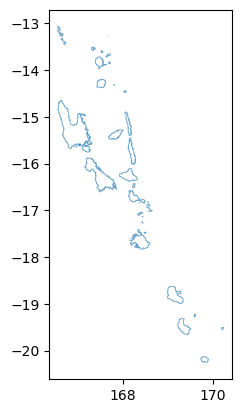

In [90]:
grids_vu.plot()

In [108]:
grids_vu = gpd.clip(grids_vu, eez_vanuatu)
grids_vu.to_file("grids_vu.geojson")

In [92]:
# Get some seagrass data for the area
client = Client.open("https://stac.digitalearthpacific.org")
items = client.search(
    collections=["dep_s2_seagrass"],
    # intersects=eez_vanuatu_geom.json
    intersects=eez_vanuatu_geom.json
).item_collection()

print(f"Found {len(items)} items")

data = load(
    items,
    bands=["seagrass"],
    crs=PACIFIC_EPSG,  # 
    resolution=100,  # Change to 10 for full resolution,
    chunks={"x": 2048, "y": 2048}
)
data

Found 136 items


<xarray.Dataset> Size: 369MB
Dimensions:      (y: 9600, x: 4800, time: 8)
Coordinates:
  * y            (y) float64 77kB -1.408e+06 -1.408e+06 ... -2.368e+06
  * x            (x) float64 38kB 1.8e+06 1.8e+06 1.8e+06 ... 2.28e+06 2.28e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
Data variables:
    seagrass     (time, y, x) uint8 369MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [93]:
def xarray_calculate_area(
    data: Dataset | DataArray,
    geom: Geometry,
    variable: str | None = None,
    value: int | float | None = None,
) -> float:
    # Work with a dataarray, not a dataset, so it's a singular thing
    if type(data) is not DataArray:
        if variable is None:
            raise ValueError("Variable must be specified when data is a Dataset.")
        data = data[variable]

    # Only select a specific value. This will convert to float, with nans
    if value is not None:
        data = data.where(data == value)

    # Mask out regions outsize the geometry
    masked = mask(data, geom.to_crs(data.odc.crs))

    # Count all the non-nan cells, and multiply by area
    count = float(masked.notnull().sum().values)
    one_pixel_area = abs(
        masked.odc.geobox.resolution.x * masked.odc.geobox.resolution.y
    )

    return float(count) * one_pixel_area

In [94]:
# Run the xarray_calculate_area per time step
results = []
for time in data.time:
    da = data.sel(time=time)
    area_m2 = xarray_calculate_area(da, eez_vanuatu_geom, variable="seagrass", value=1)
    # Year, in YYYY, area in m2, area in km2
    results.append({
        "time": pd.to_datetime(time.values).year,
        "area_m2": area_m2,
        "area_km2": area_m2 / 1e6
    })

df = pd.DataFrame(results)
df

,time,area_m2,area_km2
0,2017,59430000.0,59.43
1,2018,64050000.0,64.05
2,2019,64720000.0,64.72
3,2020,60100000.0,60.10
4,2021,64640000.0,64.64
5,2022,55790000.0,55.79
6,2023,60550000.0,60.55
7,2024,64760000.0,64.76


<Axes: title={'center': 'Vanuatu Seagrass Area Over Time'}, xlabel='time'>

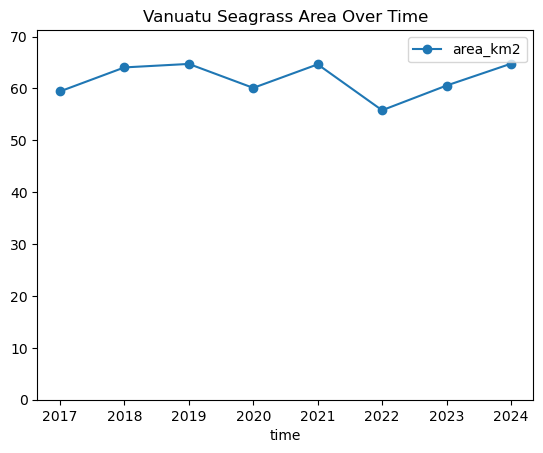

In [95]:
df.plot(x="time", y="area_km2", marker="o", title="Vanuatu Seagrass Area Over Time", ylim=(0, df["area_km2"].max() * 1.1))

In [96]:
for r in results:
    print(f"{r['time']}: {r['area_km2']:.2f} km²")

2017: 59.43 km²
2018: 64.05 km²
2019: 64.72 km²
2020: 60.10 km²
2021: 64.64 km²
2022: 55.79 km²
2023: 60.55 km²
2024: 64.76 km²


In [97]:
data

<xarray.Dataset> Size: 369MB
Dimensions:      (y: 9600, x: 4800, time: 8)
Coordinates:
  * y            (y) float64 77kB -1.408e+06 -1.408e+06 ... -2.368e+06
  * x            (x) float64 38kB 1.8e+06 1.8e+06 1.8e+06 ... 2.28e+06 2.28e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
Data variables:
    seagrass     (time, y, x) uint8 369MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [98]:
seagrass_change_2018_2024 = data.seagrass.isel(time=7) - data.seagrass.isel(time=1)

In [99]:
seagrass_2024 = data.seagrass.isel(time=7)
area_m2_seagrass_2024 =  xarray_calculate_area(seagrass_2024, eez_vanuatu_geom, variable="seagrass", value=1)
area_m2_seagrass_2024
area_km2_seagrass_2024 = area_m2_seagrass_2024/1000000
area_km2_seagrass_2024

64.76

In [100]:
seagrass_2018 = data.seagrass.isel(time=1)
area_m2_seagrass_2018 =  xarray_calculate_area(seagrass_2018, eez_vanuatu_geom, variable="seagrass", value=1)
area_m2_seagrass_2018
area_km2_seagrass_2018 = area_m2_seagrass_2018/1000000
area_km2_seagrass_2018

64.05

In [101]:
from matplotlib import colors

static_classes = [
    [255, "No_data_1", "#850000", "maroon"],
    [254, "No_data_2", "#eaed34", "yellow"],
    [0, "No_seagrass", "#ffa200", "orange"],
    [1, "Seagrass", "#4ffffa", "teal"],
    [2, "Other", "#00000000", "transparent"]
]

values_list = [c[0] for c in static_classes]
static_color_list = [c[2] for c in static_classes]

static_color_list = [cd[2] for cd in static_classes]
bounds = values_list + [5]
static_cmap = colors.ListedColormap(static_color_list)
norm = colors.BoundaryNorm(bounds, cd_map.N)

In [103]:
# data.seagrass.isel(time=7).odc.explore(cmap = static_cmap)
data.seagrass.isel(time=7).odc.explore(cmap='viridis')

In [82]:
seagrass_change_2018_2024 = data.seagrass.isel(time=7)*-2 - data.seagrass.isel(time=1)

In [83]:
area_m2 = xarray_calculate_area(seagrass_change_2018_2024, eez_vanuatu_geom, variable="seagrass", value=1)

In [84]:
km2 = area_m2/1000000
km2

0.0

In [85]:
ha = km2*100
ha

0.0

In [73]:
seagrass_change_2018_2024

<xarray.DataArray 'seagrass' (y: 9600, x: 4800)> Size: 92MB
dask.array<sub, shape=(9600, 4800), dtype=int16, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 77kB -1.408e+06 -1.408e+06 ... -2.368e+06
  * x            (x) float64 38kB 1.8e+06 1.8e+06 1.8e+06 ... 2.28e+06 2.28e+06
    spatial_ref  int32 4B 3832

In [105]:
from matplotlib import colors

change_classes = [
    [-765, "No_data_1", "#00000000", "transparent"],
    [-511, "No_data_2", "#00000000", "transparent"],
    [-510, "No_data_3", "#00000000", "transparent"],
    [-257, "No_data_4", "#00000000", "transparent"],
    [-255, "No_data_5", "#00000000", "transparent"],
    [-3, "Increasing", "#4ffffa", "teal"],
    [-2, "Decreasing", "#850000", "maroon"],
    [-1, "Constant", "#eaed34", "yellow"]
]

values_list = [c[0] for c in cd_classes]
cd_color_list = [c[2] for c in cd_classes]

cd_color_list = [cd[2] for cd in cd_classes]
bounds = values_list + [8]
cd_map = colors.ListedColormap(cd_color_list)
norm = colors.BoundaryNorm(bounds, cd_map.N)

seagrass_change_2018_2024.odc.explore(cmap =  cd_map)

In [107]:
seagrass_change_2018_2024.plot(cmap=static_map)

NameError: name 'static_map' is not defined

In [74]:
seagrass_change_2018_2024.odc.explore()

In [21]:
# seagrass_change_2018_2024.odc.write_cog("seagrass_change_2018_2024_vu.tiff", overwrite=True)

PosixPath('seagrass_change_2018_2024_fj.tiff')

In [22]:
# seagrass_2018.odc.write_cog("seagrass_2018_vu.tiff")

PosixPath('seagrass_2018_fj.tiff')

In [23]:
# seagrass_2024.odc.write_cog("seagrass_2024_vu.tiff")

PosixPath('seagrass_2024_fj.tiff')